In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning as L
from collections import OrderedDict
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN import EndToEndConvNN
from EndToEndConvNN_PL import EndToEndConvNN_PL

import sys
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

In [3]:
# data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_13-characterization_dataset"
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_13-characterization_dataset_mockup"
dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
h5py_file = h5py.File(f"{data_dir_name}/responses.hdf5",'r')["responses"]

In [4]:
fish = dataset["fish"]["dataframe"]["objs"][0]
base_stim = dataset["electric_images"]["base"]["responses"][0]
modulation = (h5py_file[34] / base_stim - 1) * 100
modulation[fish.get_receptors_locations()[:,0]< -0.11] = 0

In [5]:
fish.visualize_scatter(intensity=modulation[:,0], show_normals=1, show_point_currents=5, marker_alpha=1)
print()

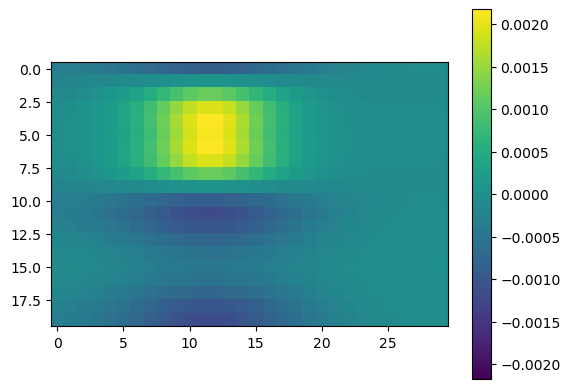

In [6]:
img_data = modulation.reshape(30,20,2).transpose(1,0,2)[:,:,1]
vval = np.max(np.abs(img_data))
plt.imshow(img_data, cmap="viridis", vmin=-vval, vmax=vval)
plt.colorbar()
plt.show()

In [7]:
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)

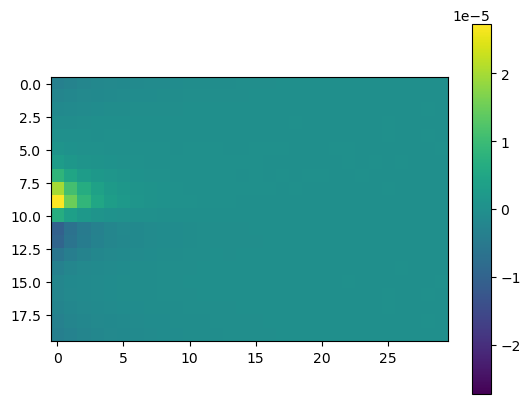

In [8]:
img_data = dset[0][0][1]
vval = np.max(np.abs(img_data))
plt.imshow(img_data, cmap="viridis", vmin=-vval, vmax=vval)
plt.colorbar()
plt.show()

In [9]:
dloader = DataLoader(dset, batch_size=4, shuffle=True)
batch = next(iter(dloader))
batch[0].shape, batch[1].shape

(torch.Size([4, 2, 20, 30]), torch.Size([4, 6]))

In [10]:
activation = "relu"
layers_properties = OrderedDict(
    [
        (
            "conv1",
            dict(in_channels=2, out_channels=8, kernel_size=5, stride=1, max_pool=dict(kernel_size=3, stride=1)),
        ),
        (
            "conv2",
            dict(in_channels=8, out_channels=32, kernel_size=5, stride=1, max_pool=dict(kernel_size=3, stride=1)),
        ),
        (
            "conv3",
            dict(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
            ),
        ),
        (
            "conv4",
            dict(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
            ),
        ),
        (
            "conv5",
            dict(in_channels=64, out_channels=32, kernel_size=3, stride=1, max_pool=dict(kernel_size=3, stride=2)),
        ),
        # the fully connected layers can have dropout or flatten layers - some can miss the activation
        ("fc1", dict(dropout=0.5, flatten=True, in_features=None, out_features=512)),
        ("fc2", dict(dropout=0.5, in_features=512, out_features=512)),
        ("fc3", dict(in_features=512, out_features=6, activation=False)),
    ]
)
if activation.lower() == "relu":
    activation = nn.ReLU()
elif activation.lower() == "tanh":
    activation = nn.Tanh()
else:
    raise ValueError(f"Activation {activation} not yet supported.")
model = EndToEndConvNN(layers_properties=layers_properties, activation=activation) # type: ignore

/opt/anaconda3/envs/efish/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



In [11]:
out_model = model.forward_print_dims(batch[0])

torch.Size([4, 2, 20, 30])
Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 0), padding_mode=circular)
torch.Size([4, 8, 20, 26])
--------------------------------------------------------------------------------------------------
BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([4, 8, 20, 26])
--------------------------------------------------------------------------------------------------
ReLU()
torch.Size([4, 8, 20, 26])
--------------------------------------------------------------------------------------------------
CircularPad2d((0, 0, 1, 1))
torch.Size([4, 8, 22, 26])
--------------------------------------------------------------------------------------------------
MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
torch.Size([4, 8, 20, 24])
--------------------------------------------------------------------------------------------------
Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 0), pa

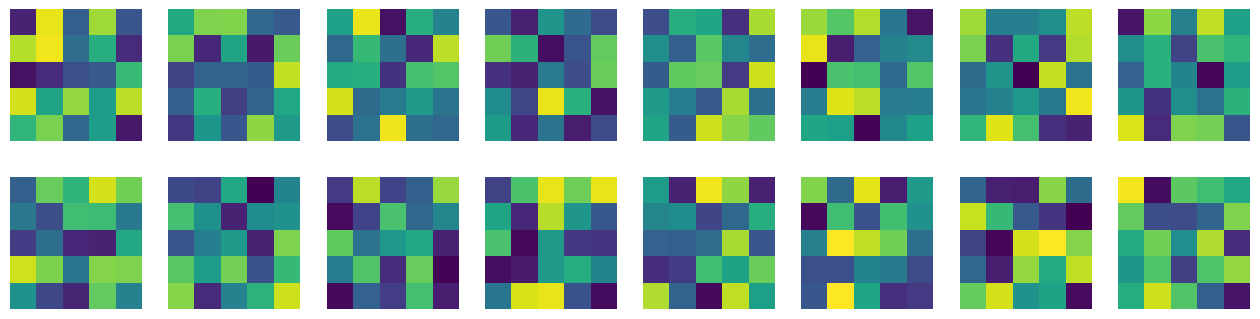

In [12]:
filters = model.sequence.conv1.conv.weight.detach().cpu().numpy()
vval = np.max(np.abs(filters))
f, ax = plt.subplots(filters.shape[1], filters.shape[0], figsize=(2*filters.shape[0], 2*filters.shape[1]))
for i in range(filters.shape[1]):
    for j in range(filters.shape[0]):
        cbar_ax = ax[i, j].imshow(filters[j, i], cmap="viridis", vmin=-vval, vmax=vval)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        sns.despine(ax=ax[i, j], left=True, bottom=True)
plt.show()

In [13]:
train_dset, valid_dset = torch.utils.data.random_split(dset, [0.8, 0.2])
train_loader = DataLoader(train_dset, batch_size=64, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dset, batch_size=64, shuffle=False, drop_last=True)

model_PL = EndToEndConvNN_PL(model)

trainer = L.Trainer(max_steps=1000)
trainer.fit(model=model_PL, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type           | Params
-----------------------------------------
0 | model | EndToEndConvNN | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.666     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/efish/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/opt/anaconda3/envs/efish/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/opt/anaconda3/envs/efish/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
